# 4. Training Visualization

In this notebook, using the previously collected Loss and Accuracy metrics, we plot the learning curves over the course of training.

## Short goal and logic
Set up the working environment for a PyTorch project: model building, data loading/augmentation, optimization, visualization, serialization, and utilities. No computations here—just imports.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, sys, gc
import time
from datetime import datetime
import copy
import random
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop
from PIL import Image
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from types import resolve_bases
import pickle
from sklearn.model_selection import train_test_split
import cloudpickle
from scipy.ndimage import gaussian_filter1d
import os
from pathlib import Path

## Short goal and logic
Load three saved training reports, merge their metric histories into continuous series, print final accuracies, and visualize losses/accuracies. For “gold” metrics, show both moving-average and Gaussian-smoothed curves to reveal trends.

## Key variables and how they are used
* res0, res1, res2: dicts loaded from pickle files; expected keys: hist_loss_train/val/gold, hist_acc_train/val/gold.
* hist_loss_train, hist_acc_train, hist_loss_val, hist_acc_val, hist_loss_gold, hist_acc_gold: merged metric time series from the three runs.
* epoch: length of hist_loss_train; x-axis for plots.
* window_size (7), weights: moving-average parameters (uniform weights).
* pad_left, pad_right, padded: edge padding to keep length after convolution.
* loss_gold, acc_gold: moving-averaged “gold” loss/acc.
* g_smooth: Gaussian-smoothed series for gold metrics.
* x: index array for plotting smoothed series.

acc: 0.874 0.980 0.790


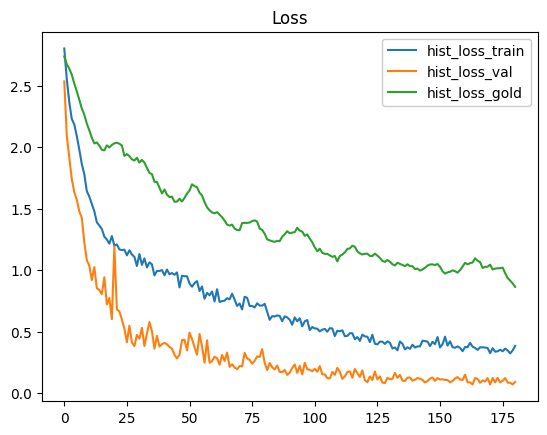

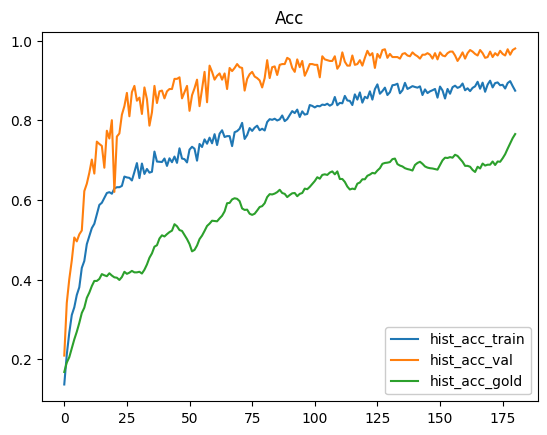

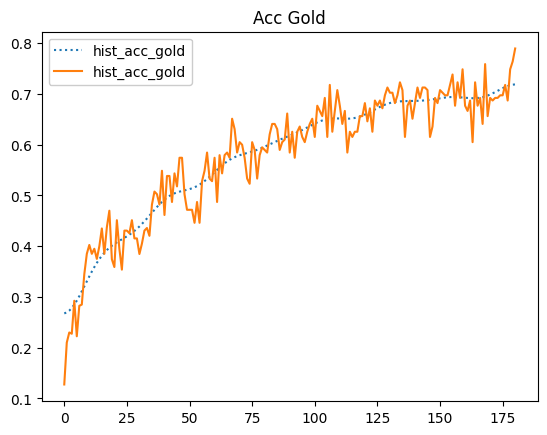

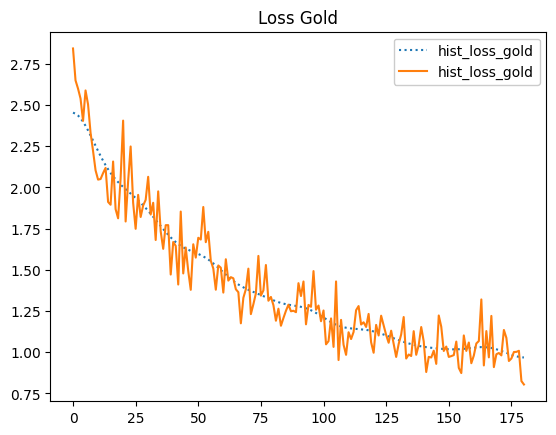

In [4]:
with open('rnn_conv_report_11.26.30.pkl', 'rb') as f:
    res2 = cloudpickle.load(f)
with open('rnn_conv_report_10.32.43.pkl', 'rb') as f:
    res1 = cloudpickle.load(f)
with open('rnn_conv_report_12.31.18.pkl', 'rb') as f:
    res0 = cloudpickle.load(f)
hist_loss_train=res0['hist_loss_train']+res1['hist_loss_train']+res2['hist_loss_train']
hist_acc_train=res0['hist_acc_train']+res1['hist_acc_train']+res2['hist_acc_train']
hist_loss_val=res0['hist_loss_val']+res1['hist_loss_val']+res2['hist_loss_val']
hist_acc_val=res0['hist_acc_val']+res1['hist_acc_val']+res2['hist_acc_val']
hist_loss_gold=res0['hist_loss_gold']+res1['hist_loss_gold']+res2['hist_loss_gold']
hist_acc_gold=res0['hist_acc_gold']+res1['hist_acc_gold']+res2['hist_acc_gold']
epoch=len(hist_loss_train)
    

clear_output(True)
print(f"acc: {hist_acc_train[-1]:0.3f} {hist_acc_val[-1]:0.3f} {hist_acc_gold[-1]:0.3f}")
plt.plot(np.arange(0,epoch),hist_loss_train,label='hist_loss_train')
plt.plot(np.arange(0,epoch),hist_loss_val,label='hist_loss_val')
window_size = 7
weights = np.ones(window_size) / window_size
pad_left = window_size // 2
pad_right = window_size - 1 - pad_left
padded = np.pad(hist_loss_gold, (pad_left, pad_right), mode='edge')
loss_gold = np.convolve(padded, weights, mode='valid')
plt.plot(np.arange(0,epoch),loss_gold,label='hist_loss_gold')
plt.legend(framealpha=1, frameon=True);
plt.title('Loss')
plt.show()
plt.plot(np.arange(0,epoch),hist_acc_train,label='hist_acc_train')
plt.plot(np.arange(0,epoch),hist_acc_val,label='hist_acc_val')
window_size = 7
weights = np.ones(window_size) / window_size
pad_left = window_size // 2
pad_right = window_size - 1 - pad_left
padded = np.pad(hist_acc_gold, (pad_left, pad_right), mode='edge')
acc_gold = np.convolve(padded, weights, mode='valid')
plt.plot(np.arange(0,epoch),acc_gold,label='hist_acc_gold')
plt.legend(framealpha=1, frameon=True);
plt.title('Acc')
plt.show()
g_smooth = gaussian_filter1d(hist_acc_gold, sigma=window_size)
x = np.arange(0,len(g_smooth))
plt.plot(x, g_smooth, label='hist_acc_gold', linestyle = 'dotted')
plt.plot(x, hist_acc_gold, label='hist_acc_gold')
plt.legend(framealpha=1, frameon=True);
plt.title('Acc Gold')
plt.show()
g_smooth = gaussian_filter1d(hist_loss_gold, sigma=window_size)
x = np.arange(0,len(g_smooth))
plt.plot(x, g_smooth, label='hist_loss_gold', linestyle = 'dotted')
plt.plot(x, hist_loss_gold, label='hist_loss_gold')
plt.legend(framealpha=1, frameon=True);
plt.title('Loss Gold')
plt.show()